In [1]:
# # mounting google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# define and move to dataset directory
datasetdir = '../dataset/Plant_leaf_diseases_dataset_with_augmentation'
import os
os.chdir(datasetdir)

In [3]:
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import tensorflow as tf
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
print('Num GPU Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPU Available:  1


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 5

def generators(shape): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        # preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1)

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width),
        batch_size = batch_size,
        subset = 'training')

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width),
        batch_size = batch_size,
        subset = 'validation')
    
    return train_dataset, val_dataset

In [6]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [7]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc')>0.9704):
            print("\nReached 97.04% accuracy so cancelling training!")
            self.model.stop_training = True

__VGG19__

In [8]:
vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
predictions = keras.layers.Dense(15, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
train_dataset, val_dataset = generators((224,224))

Found 22843 images belonging to 15 classes.
Found 2535 images belonging to 15 classes.


In [10]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])

In [11]:
callbacks = myCallback()
history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    epochs=500,
    steps_per_epoch=5,
    callbacks = [callbacks])

======] - 23s 6s/step - loss: 0.0255 - acc: 1.0000 - val_loss: 0.2825 - val_acc: 0.9136
Epoch 349/500
5/5 [==============================] - 23s 6s/step - loss: 0.5155 - acc: 0.7850 - val_loss: 0.2474 - val_acc: 0.9128
Epoch 350/500
5/5 [==============================] - 23s 6s/step - loss: 0.1371 - acc: 0.9672 - val_loss: 0.2322 - val_acc: 0.9266
Epoch 351/500
5/5 [==============================] - 23s 6s/step - loss: 0.0564 - acc: 0.9783 - val_loss: 0.1934 - val_acc: 0.9310
Epoch 352/500
5/5 [==============================] - 23s 6s/step - loss: 0.5648 - acc: 0.9172 - val_loss: 0.1863 - val_acc: 0.9345
Epoch 353/500
5/5 [==============================] - 23s 6s/step - loss: 0.0730 - acc: 0.9783 - val_loss: 0.1929 - val_acc: 0.9314
Epoch 354/500
5/5 [==============================] - 23s 6s/step - loss: 0.1849 - acc: 0.9506 - val_loss: 0.1690 - val_acc: 0.9381
Epoch 355/500
5/5 [==============================] - 23s 6s/step - loss: 0.0633 - acc: 0.9783 - val_loss: 0.1635 - val_acc: 0.

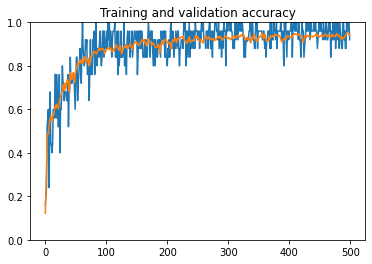

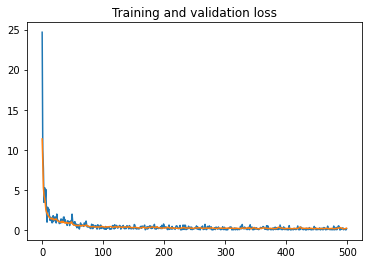

In [13]:
plot_history(history, yrange=(0,1))

In [ ]:
os.chdir('../../')

In [17]:
# save the model in SavedModel format
full_model.save("model/mobilenet_disease_detection_saved_model")

INFO:tensorflow:Assets written to: model/mobilenet_disease_detection_saved_model\assets


In [ ]:
# !zip -r /content/model.zip /content/drive/MyDrive/Capstone/plant_disease_detection/model

In [18]:
# load SavedModel model
model = keras.models.load_model('model/mobilenet_disease_detection_saved_model')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

__Predict Image__

In [ ]:
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves',
               'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight',
               'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
               'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']

In [ ]:
image_path = '/content/drive/MyDrive/Capstone/plant_disease_detection/Corn___Cercospora_leaf_spot Gray_leaf_spot_test_image.png'

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

In [ ]:
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
image_test = preprocess_input(img_batch)

In [ ]:
prediction = model.predict(image_test)[0]

In [ ]:
print(prediction)

In [ ]:
class_names[np.argmax(prediction)]

__TFLite Model__

In [19]:
# convert SavedModel to tflite
saved_model_dir = 'model/mobilenet_disease_detection_saved_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# save tflite model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

---

In [ ]:
interpreter = tf.lite.Interpreter(
    model_path="/content/drive/MyDrive/Capstone/plant_disease_detection/model.tflite"
)

In [ ]:
interpreter.allocate_tensors()

In [ ]:
interpreter.get_input_details()

In [ ]:
img = image.load_img(image_path, target_size=(224, 224))

In [ ]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
interpreter.set_tensor(input_index, img_batch)
interpreter.invoke()

In [ ]:
prediction = interpreter.get_tensor(output_index)

In [ ]:
class_names[np.argmax(prediction)]

In [ ]:
print(img_batch.dtype)